In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

files = {
    "pss_pre": "./data/PSS/PSS_Pre.csv",
    "pss_post": "./data/PSS/PSS_Post.csv",
    "phq9_pre": "./data/PHQ-9/PHQ-9_Pre.csv",
    "phq9_post": "./data/PHQ-9/PHQ-9_Post.csv",
    "loneliness_pre": "./data/LonelinessScale/LonelinessScale_Pre.csv",
    "loneliness_post": "./data/LonelinessScale/LonelinessScale_Post.csv",
    "flourishing_pre": "./data/FlourishingScale/FlourishingScale_Pre.csv",
    "flourishing_post": "./data/FlourishingScale/FlourishingScale_Post.csv"
}

def load_data(filepath):
    return pd.read_csv(filepath)

# Load all survey data
survey_data = {name: load_data(path) for name, path in files.items()}

# Load GPA data
gpa_data = load_data("./education/grades.csv")


In [18]:
def calculate_change(pre_df, post_df):
    pre_df = pre_df[['uid', 'total_score']].rename(columns={'total_score': 'score_pre'})
    post_df = post_df[['uid', 'total_score']].rename(columns={'total_score': 'score_post'})
    change_df = pd.merge(pre_df, post_df, on='uid')
    change_df['score_change'] = change_df['score_post'] - change_df['score_pre']
    return change_df[['uid', 'score_change']]

changes = {
    survey_key.replace('_pre', ''): calculate_change(survey_data[survey_key], survey_data[survey_key.replace('_pre', '_post')])
    for survey_key in survey_data if '_pre' in survey_key
}

combined_changes = gpa_data[['uid', 'gpa_all', 'gpa_13s', 'cs_65']].copy()
for key, change_df in changes.items():
    combined_changes = pd.merge(combined_changes, change_df, on='uid', how='left', suffixes=('', f'_{key}'))

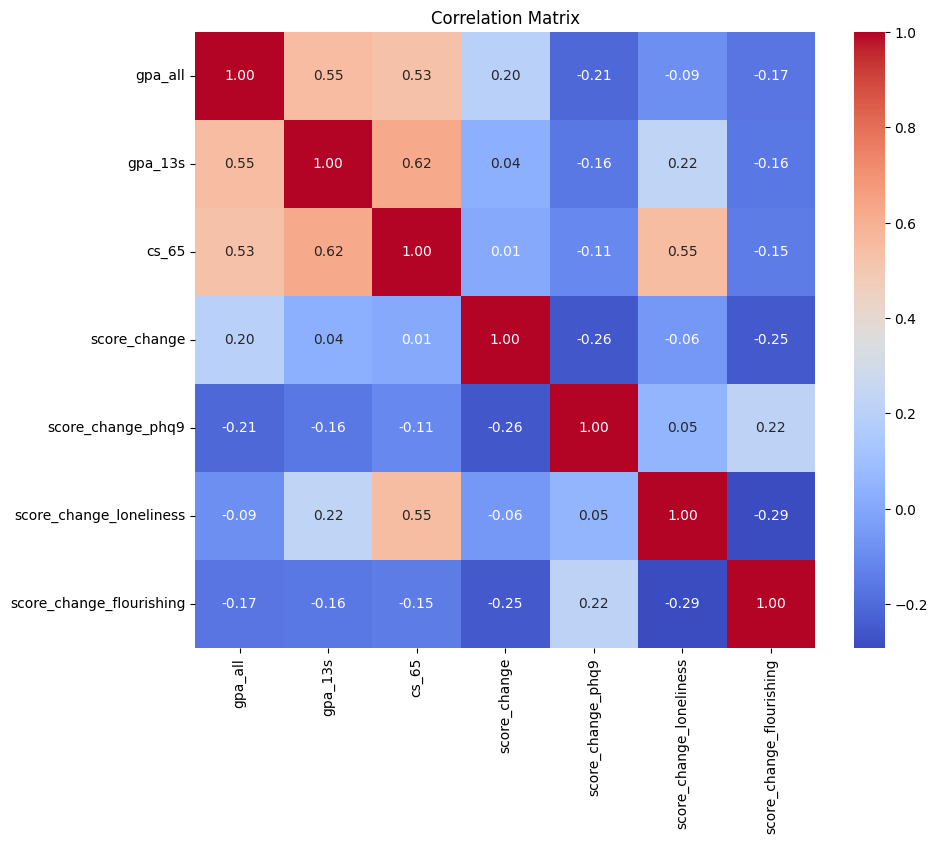

In [19]:
def plot_correlation_matrix(data):
    # Select only numeric columns for the correlation matrix
    numeric_data = data.select_dtypes(include=[float, int])
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(combined_changes)

In [21]:
def perform_regression(dependent_var, data, changes):
    # Ensure that the correct survey change columns are referenced
    survey_change_columns = [f'score_change_{key}' for key in changes.keys() if f'score_change_{key}' in data.columns]
    X = sm.add_constant(data[survey_change_columns].fillna(0))
    Y = data[dependent_var]
    model = sm.OLS(Y, X).fit()
    return model.summary()

# Assuming you have a dictionary `changes` that includes all surveys
results = {metric: perform_regression(metric, combined_changes, changes) for metric in ['gpa_all', 'gpa_13s', 'cs_65']}
for metric, result in results.items():
    print(f"Regression results for {metric}:\n{result}\n")

Regression results for gpa_all:
                            OLS Regression Results                            
Dep. Variable:                gpa_all   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                    0.5488
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.653
Time:                        06:12:55   Log-Likelihood:                -13.481
No. Observations:                  30   AIC:                             34.96
Df Residuals:                      26   BIC:                             40.57
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------